# Time Series - TensorFlow
Provincial with no series manipulation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from ts import *
from utils import *
from tfts import *

import tensorflow as tf

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

## Activation functions

In [5]:
x = np.arange(-5, 5, 0.01)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return 2 / (1 + np.exp(-2 * x)) -1

def softmax(x):
    return np.exp(x) / float(sum(np.exp(x)))

relu = np.vectorize(lambda x: x if x > 0 else 0, otypes=[np.float])
leaky_relu = np.vectorize(lambda x: max(0.1 * x, x), otypes=[np.float])

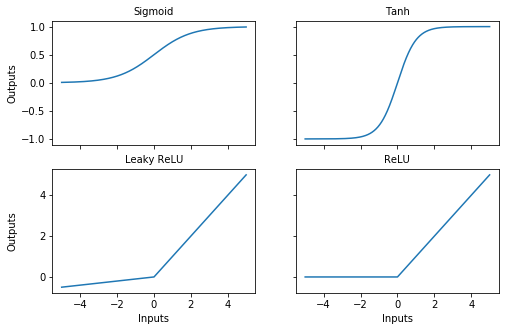

In [6]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(8,5))
(ax1, ax2), (ax3, ax4) = axs
ax1.plot(x, sigmoid(x))
ax2.plot(x, tanh(x))
ax3.plot(x, leaky_relu(x))
ax4.plot(x, relu(x))

axs[0, 0].set_title('Sigmoid', fontsize=10)
axs[0, 1].set_title('Tanh', fontsize=10)
axs[1, 0].set_title('Leaky ReLU', fontsize=10)
axs[1, 1].set_title('ReLU', fontsize=10)

for ax in axs.flat:
    ax.set(xlabel='Inputs', ylabel='Outputs')
    ax.label_outer()

fig.align_ylabels(axs[:, 0])

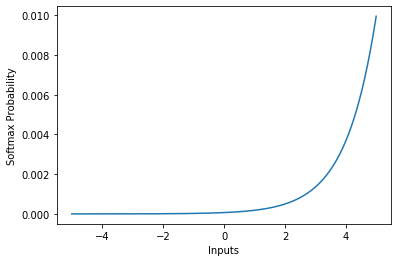

In [7]:
plt.plot(x, softmax(x))
plt.xlabel("Inputs")
plt.ylabel("Softmax Probability")
plt.show()

## Load data

In [5]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

In [57]:
df = covidpro_df[covidpro_df.Province == province].query('20200701 > Date')

In [58]:
df = df.set_index(date)

In [59]:
df_orig = df.copy()
df = df.loc[:, ['New_cases']]

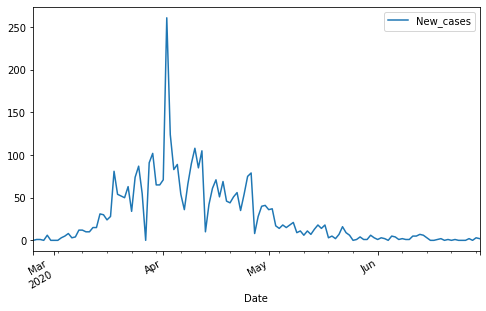

In [9]:
df.plot(subplots=True, figsize=(8,5))
plt.show()

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
New_cases,128.0,27.570312,37.069563,0.0,2.0,10.5,47.0,261.0


In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.4)]
val_df = df[int(n*0.4):int(n*0.7)]
test_df = df[int(n*0.7):]

num_features = df.shape[1]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [13]:
len(train_df), len(val_df), len(test_df)

(51, 38, 39)

## Single step

In [14]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])
    
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['New_cases']

In [15]:
baseline = Baseline(label_index=column_indices[compart])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), 
                          tf.metrics.MeanSquaredError()])

val_performance = {}
performance = {}

In [16]:
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

2/2 [==============================] - 0s 2ms/step - loss: 0.1114 - mean_absolute_error: 0.2133 - mean_squared_error: 0.1114


In [17]:
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

### Wide window

In [18]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=14,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

wide_window

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): ['New_cases']

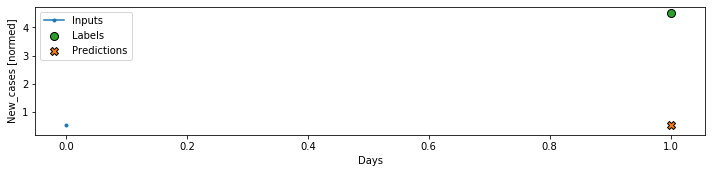

In [19]:
single_step_window.plot(baseline)

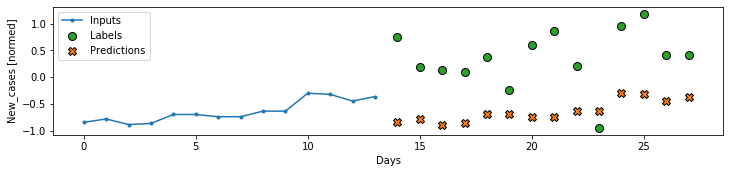

In [20]:
wide_window.plot(baseline)

In [21]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [22]:
history = compile_and_fit(linear, single_step_window)

======================] - 0s 44ms/step - loss: 4.2684 - mean_absolute_error: 1.6478 - mean_squared_error: 4.2684 - val_loss: 1.6269 - val_mean_absolute_error: 1.1068 - val_mean_squared_error: 1.6269
Epoch 13/100
2/2 [==============================] - 0s 36ms/step - loss: 4.2617 - mean_absolute_error: 1.6465 - mean_squared_error: 4.2617 - val_loss: 1.6249 - val_mean_absolute_error: 1.1060 - val_mean_squared_error: 1.6249
Epoch 14/100
2/2 [==============================] - 0s 52ms/step - loss: 4.2546 - mean_absolute_error: 1.6452 - mean_squared_error: 4.2546 - val_loss: 1.6224 - val_mean_absolute_error: 1.1052 - val_mean_squared_error: 1.6224
Epoch 15/100
2/2 [==============================] - 0s 39ms/step - loss: 4.2467 - mean_absolute_error: 1.6438 - mean_squared_error: 4.2467 - val_loss: 1.6200 - val_mean_absolute_error: 1.1043 - val_mean_squared_error: 1.6200
Epoch 16/100
2/2 [==============================] - 0s 43ms/step - loss: 4.2412 - mean_absolute_error: 1.6425 - mean_squared_e

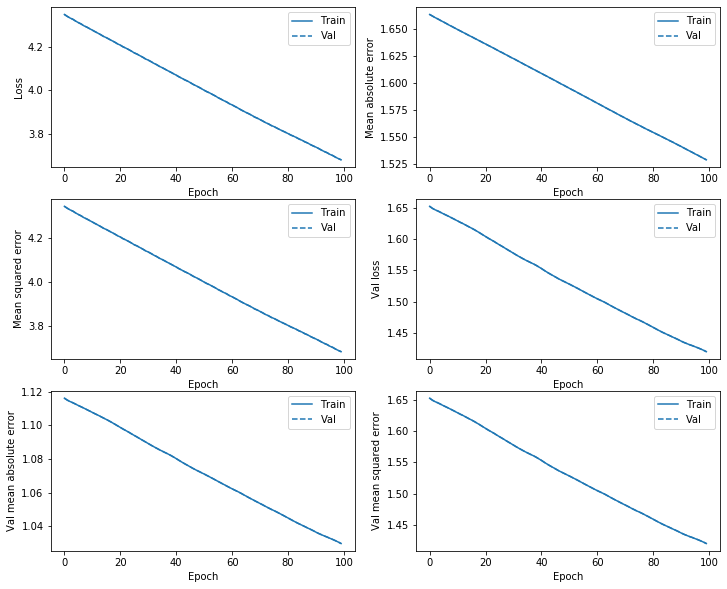

In [23]:
plot_metrics(history)

In [24]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)

2/2 [==============================] - 0s 1ms/step - loss: 1.4200 - mean_absolute_error: 1.0299 - mean_squared_error: 1.4200


In [25]:
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

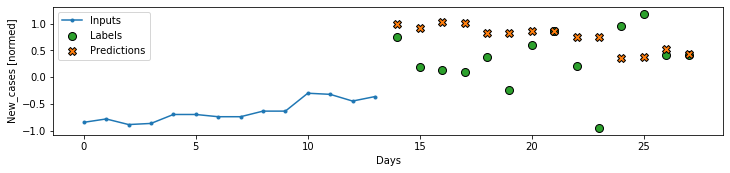

In [26]:
wide_window.plot(linear)

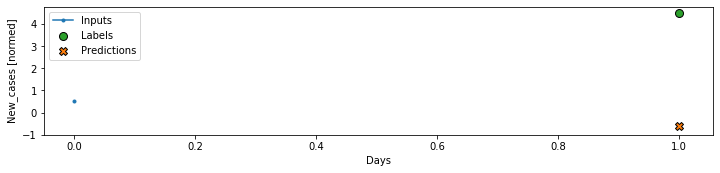

In [27]:
single_step_window.plot(linear)

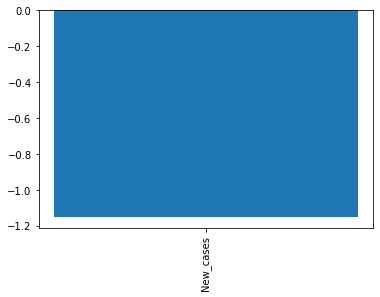

In [28]:
# Show weights
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
axis.set_xticklabels(train_df.columns, rotation=90)
plt.show()

In [29]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

Epoch 1/100
2/2 [==============================] - 0s 152ms/step - loss: 0.8802 - mean_absolute_error: 0.6979 - mean_squared_error: 0.8802 - val_loss: 0.2443 - val_mean_absolute_error: 0.4349 - val_mean_squared_error: 0.2443
Epoch 2/100
2/2 [==============================] - 0s 44ms/step - loss: 0.8152 - mean_absolute_error: 0.6576 - mean_squared_error: 0.8152 - val_loss: 0.2154 - val_mean_absolute_error: 0.4058 - val_mean_squared_error: 0.2154
Epoch 3/100
2/2 [==============================] - 0s 40ms/step - loss: 0.7632 - mean_absolute_error: 0.6177 - mean_squared_error: 0.7632 - val_loss: 0.1901 - val_mean_absolute_error: 0.3797 - val_mean_squared_error: 0.1901
Epoch 4/100
2/2 [==============================] - 0s 37ms/step - loss: 0.7234 - mean_absolute_error: 0.5883 - mean_squared_error: 0.7234 - val_loss: 0.1670 - val_mean_absolute_error: 0.3536 - val_mean_squared_error: 0.1670
Epoch 5/100
2/2 [==============================] - 0s 36ms/step - loss: 0.6859 - mean_absolute_error: 0

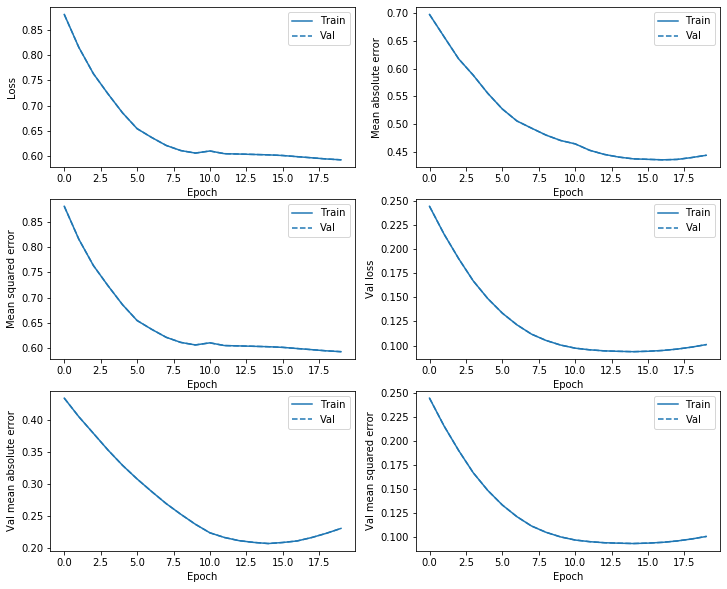

In [30]:
plot_metrics(history)

In [31]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

2/2 [==============================] - 0s 1ms/step - loss: 0.1009 - mean_absolute_error: 0.2307 - mean_squared_error: 0.1009


In [32]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [33]:
CONV_WIDTH = 14
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

conv_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['New_cases']

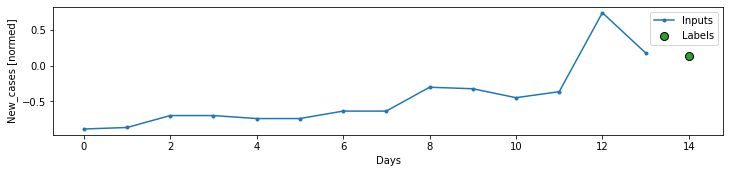

In [34]:
conv_window.plot()

In [35]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [36]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/100
2/2 [==============================] - 0s 84ms/step - loss: 1.2676 - mean_absolute_error: 0.8300 - mean_squared_error: 1.2676 - val_loss: 0.4772 - val_mean_absolute_error: 0.6523 - val_mean_squared_error: 0.4772
Epoch 2/100
2/2 [==============================] - 0s 29ms/step - loss: 1.1661 - mean_absolute_error: 0.7848 - mean_squared_error: 1.1661 - val_loss: 0.4770 - val_mean_absolute_error: 0.6572 - val_mean_squared_error: 0.4770
Epoch 3/100
2/2 [==============================] - 0s 34ms/step - loss: 1.0732 - mean_absolute_error: 0.7466 - mean_squared_error: 1.0732 - val_loss: 0.4699 - val_mean_absolute_error: 0.6563 - val_mean_squared_error: 0.4699
Epoch 4/100
2/2 [==============================] - 0s 31ms/step - loss: 1.0032 - mean_absolute_error: 0.7147 - mean_squared_error: 1.0032 - val_loss: 0.4622 - val_mean_absolute_error: 0.6543 - val_mean_squared_error: 0.4622
Epoch 5/100
2/2 [==============================] - 0s 27ms/step - loss: 0.9527 - mean_absolute_error: 0.

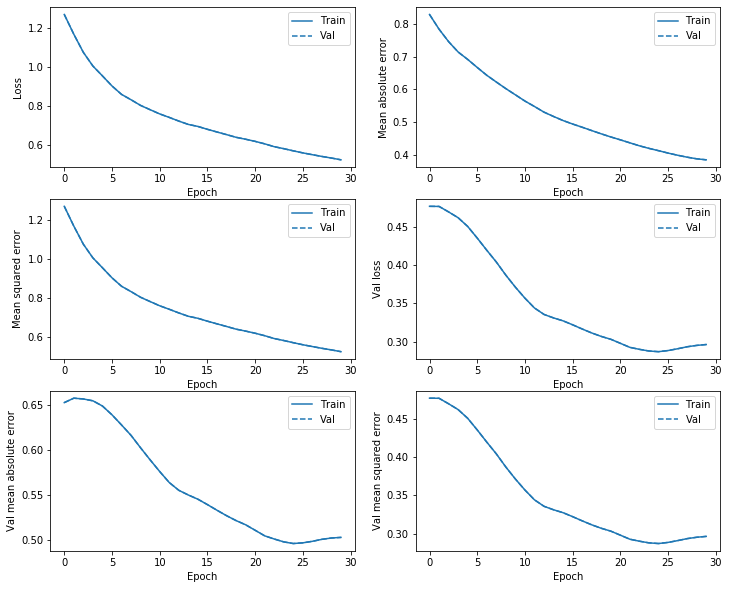

In [37]:
plot_metrics(history)

In [38]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.2962 - mean_absolute_error: 0.5028 - mean_squared_error: 0.2962


In [39]:
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

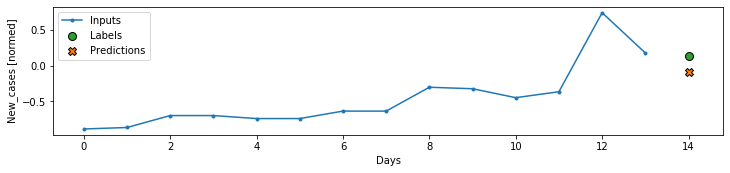

In [40]:
conv_window.plot(multi_step_dense)

In [41]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [42]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/100
1/1 [==============================] - 0s 440ms/step - loss: 1.2947 - mean_absolute_error: 0.7636 - mean_squared_error: 1.2947 - val_loss: 0.4624 - val_mean_absolute_error: 0.6597 - val_mean_squared_error: 0.4624
Epoch 2/100
1/1 [==============================] - 0s 52ms/step - loss: 1.2801 - mean_absolute_error: 0.7557 - mean_squared_error: 1.2801 - val_loss: 0.4706 - val_mean_absolute_error: 0.6656 - val_mean_squared_error: 0.4706
Epoch 3/100
1/1 [==============================] - 0s 67ms/step - loss: 1.2664 - mean_absolute_error: 0.7479 - mean_squared_error: 1.2664 - val_loss: 0.4789 - val_mean_absolute_error: 0.6715 - val_mean_squared_error: 0.4789
Epoch 4/100
1/1 [==============================] - 0s 62ms/step - loss: 1.2534 - mean_absolute_error: 0.7402 - mean_squared_error: 1.2534 - val_loss: 0.4873 - val_mean_absolute_error: 0.6774 - val_mean_squared_error: 0.4873
Epoch 5/100
1/1 [==============================] - 0s 64ms/step - loss: 1.2413 - mean_absolute_error: 0

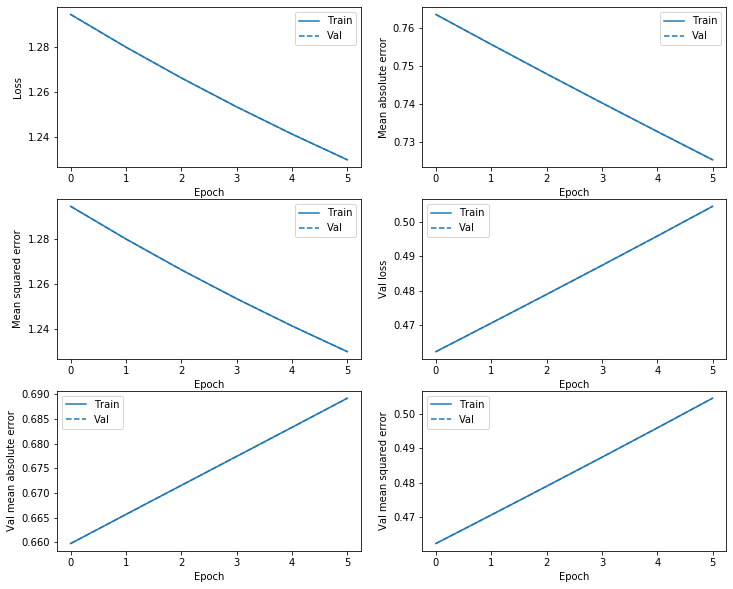

In [43]:
plot_metrics(history)

In [44]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

1/1 [==============================] - 0s 907us/step - loss: 0.5044 - mean_absolute_error: 0.6892 - mean_squared_error: 0.5044


In [45]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

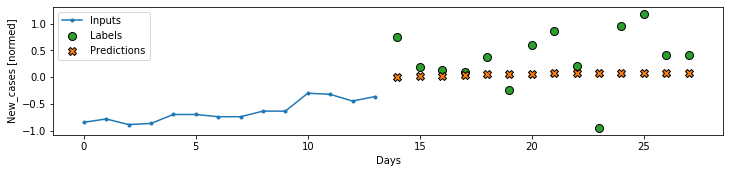

In [46]:
wide_window.plot(lstm_model)

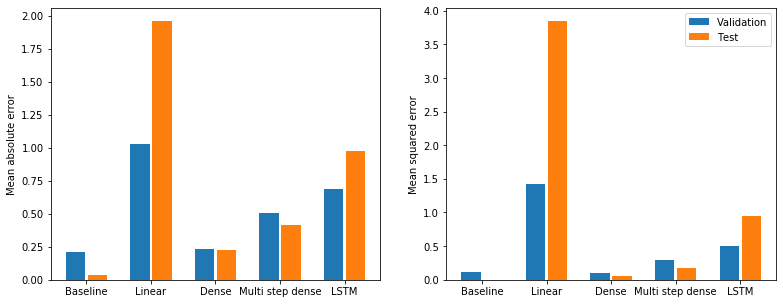

In [47]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance, figsize=(13,5))

### Multi-output

In [60]:
df = df_orig.loc[:, ['New_cases', 'Deaths']]

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.4)]
val_df = df[int(n*0.4):int(n*0.7)]
test_df = df[int(n*0.7):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [61]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=14,
    train_df=train_df, val_df=val_df, test_df=test_df)

In [62]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

In [63]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 1.2000 - mean_absolute_error: 0.8865 - mean_squared_error: 1.2000


In [64]:
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

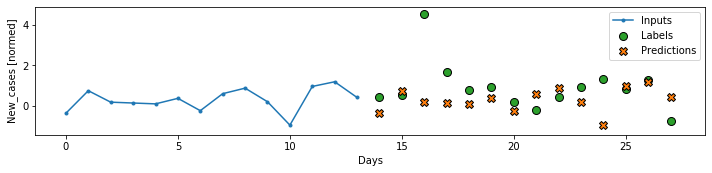

In [73]:
wide_window.plot(baseline, plot_col=compart)

In [66]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [67]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/100
2/2 [==============================] - 0s 63ms/step - loss: 1.0427 - mean_absolute_error: 0.7683 - mean_squared_error: 1.0427 - val_loss: 0.6771 - val_mean_absolute_error: 0.6187 - val_mean_squared_error: 0.6771
Epoch 2/100
2/2 [==============================] - 0s 20ms/step - loss: 0.9669 - mean_absolute_error: 0.7307 - mean_squared_error: 0.9669 - val_loss: 0.6407 - val_mean_absolute_error: 0.6022 - val_mean_squared_error: 0.6407
Epoch 3/100
2/2 [==============================] - 0s 22ms/step - loss: 0.9064 - mean_absolute_error: 0.6965 - mean_squared_error: 0.9064 - val_loss: 0.6110 - val_mean_absolute_error: 0.5901 - val_mean_squared_error: 0.6110
Epoch 4/100
2/2 [==============================] - 0s 22ms/step - loss: 0.8491 - mean_absolute_error: 0.6647 - mean_squared_error: 0.8491 - val_loss: 0.5832 - val_mean_absolute_error: 0.5785 - val_mean_squared_error: 0.5832
Epoch 5/100
2/2 [==============================] - 0s 21ms/step - loss: 0.8052 - mean_absolute_error: 0.

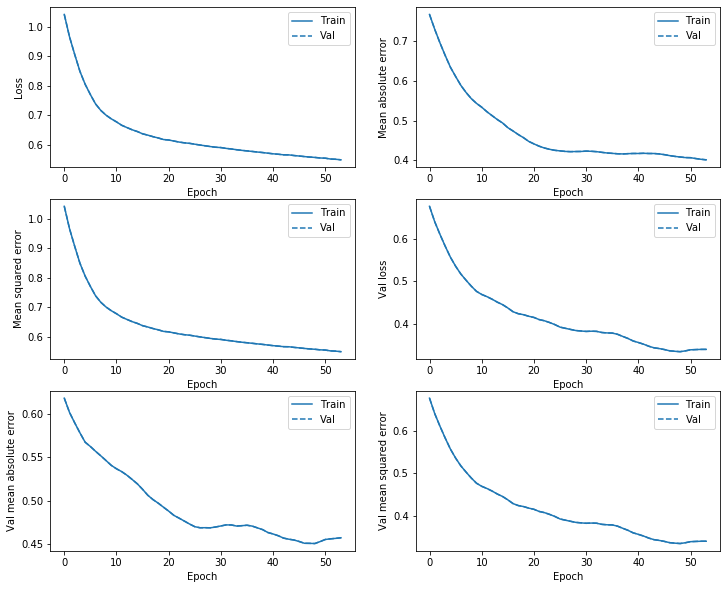

In [68]:
plot_metrics(history)

In [69]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

2/2 [==============================] - 0s 2ms/step - loss: 0.3400 - mean_absolute_error: 0.4570 - mean_squared_error: 0.3400


In [70]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

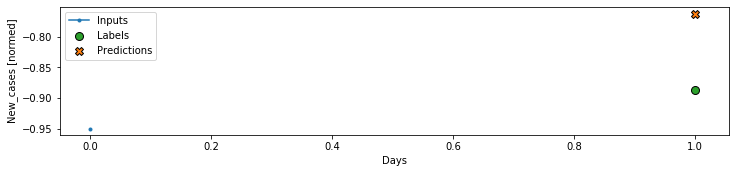

In [71]:
single_step_window.plot(dense, plot_col=compart)

In [74]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=14,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

Epoch 1/100
1/1 [==============================] - 0s 348ms/step - loss: 1.0269 - mean_absolute_error: 0.6628 - mean_squared_error: 1.0269 - val_loss: 0.4331 - val_mean_absolute_error: 0.5808 - val_mean_squared_error: 0.4331
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 1.0143 - mean_absolute_error: 0.6565 - mean_squared_error: 1.0143 - val_loss: 0.4230 - val_mean_absolute_error: 0.5729 - val_mean_squared_error: 0.4230
Epoch 3/100
1/1 [==============================] - 0s 50ms/step - loss: 1.0024 - mean_absolute_error: 0.6504 - mean_squared_error: 1.0024 - val_loss: 0.4131 - val_mean_absolute_error: 0.5652 - val_mean_squared_error: 0.4131
Epoch 4/100
1/1 [==============================] - 0s 49ms/step - loss: 0.9912 - mean_absolute_error: 0.6443 - mean_squared_error: 0.9912 - val_loss: 0.4036 - val_mean_absolute_error: 0.5575 - val_mean_squared_error: 0.4036
Epoch 5/100
1/1 [==============================] - 0s 57ms/step - loss: 0.9806 - mean_absolute_error: 0

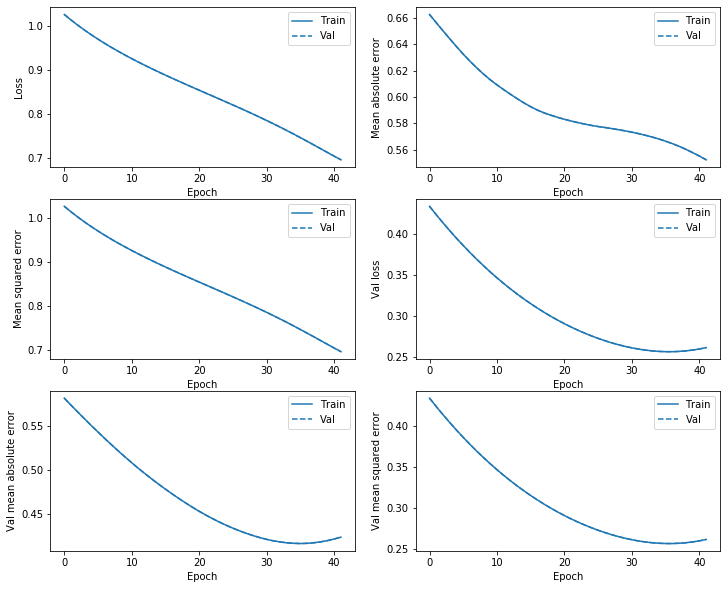

In [75]:
plot_metrics(history)

In [76]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.2620 - mean_absolute_error: 0.4245 - mean_squared_error: 0.2620


In [77]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

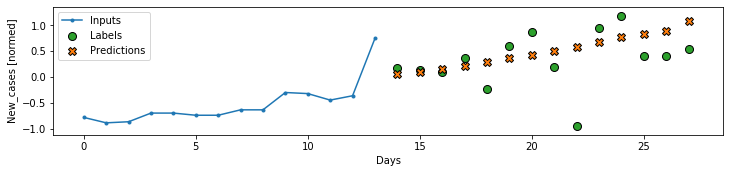

In [78]:
wide_window.plot(lstm_model, plot_col=compart)

In [79]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

Epoch 1/100
1/1 [==============================] - 0s 349ms/step - loss: 1.3563 - mean_absolute_error: 0.8306 - mean_squared_error: 1.3563 - val_loss: 1.1959 - val_mean_absolute_error: 0.8847 - val_mean_squared_error: 1.1959
Epoch 2/100
1/1 [==============================] - 0s 48ms/step - loss: 1.3528 - mean_absolute_error: 0.8292 - mean_squared_error: 1.3528 - val_loss: 1.1916 - val_mean_absolute_error: 0.8828 - val_mean_squared_error: 1.1916
Epoch 3/100
1/1 [==============================] - 0s 49ms/step - loss: 1.3491 - mean_absolute_error: 0.8277 - mean_squared_error: 1.3491 - val_loss: 1.1872 - val_mean_absolute_error: 0.8809 - val_mean_squared_error: 1.1872
Epoch 4/100
1/1 [==============================] - 0s 60ms/step - loss: 1.3451 - mean_absolute_error: 0.8261 - mean_squared_error: 1.3451 - val_loss: 1.1826 - val_mean_absolute_error: 0.8788 - val_mean_squared_error: 1.1826
Epoch 5/100
1/1 [==============================] - 0s 59ms/step - loss: 1.3409 - mean_absolute_error: 0

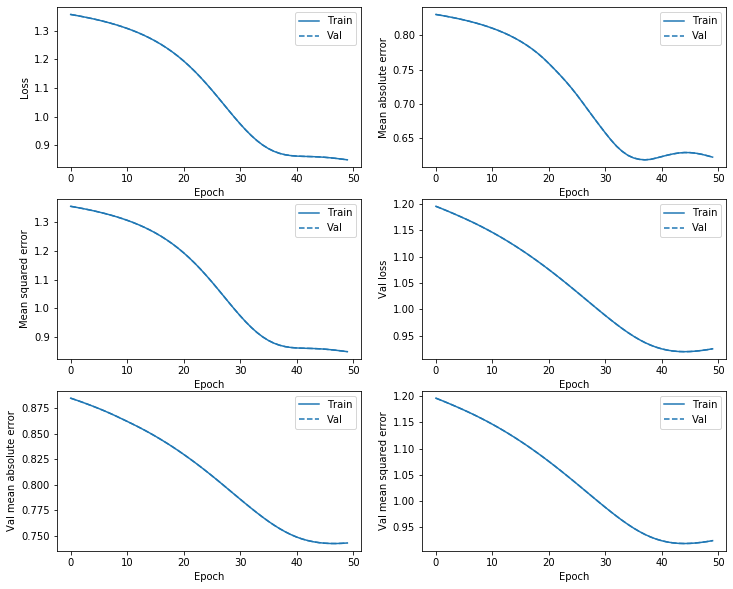

In [80]:
plot_metrics(history)

In [81]:
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.9248 - mean_absolute_error: 0.7430 - mean_squared_error: 0.9248


In [82]:
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

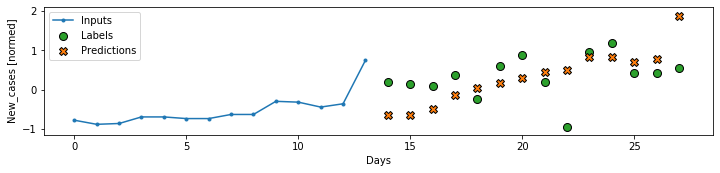

In [83]:
wide_window.plot(residual_lstm, plot_col=compart)

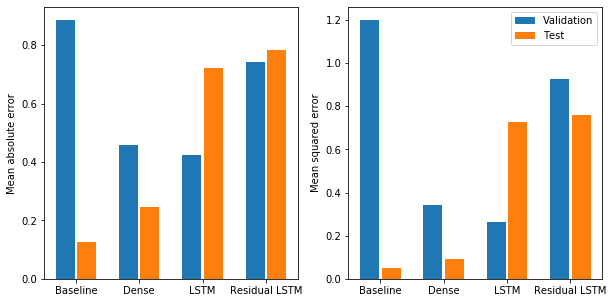

In [84]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

## Multi-step

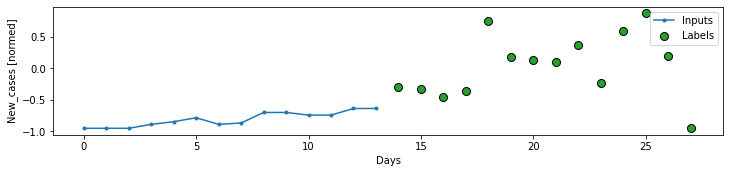

In [85]:
OUT_STEPS = 14
multi_window = WindowGenerator(
    input_width=14,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

multi_window.plot()

In [86]:
last_baseline = MultiStepLastBaseline(OUT_STEPS)
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)

In [87]:
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

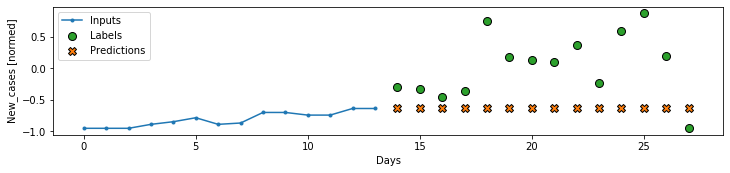

In [88]:
multi_window.plot(last_baseline)

In [89]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, verbose=0)

In [90]:
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

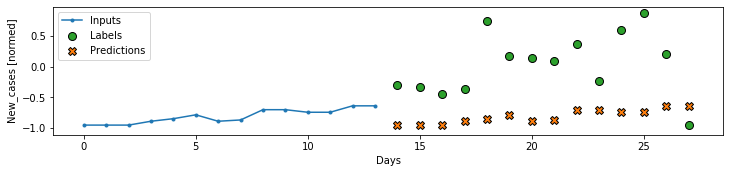

In [91]:
multi_window.plot(repeat_baseline)

### Single shot

In [92]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/100
1/1 [==============================] - 0s 116ms/step - loss: 1.0183 - mean_absolute_error: 0.6576 - mean_squared_error: 1.0183 - val_loss: 0.4426 - val_mean_absolute_error: 0.5483 - val_mean_squared_error: 0.4426
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 1.0170 - mean_absolute_error: 0.6569 - mean_squared_error: 1.0170 - val_loss: 0.4428 - val_mean_absolute_error: 0.5485 - val_mean_squared_error: 0.4428
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 1.0156 - mean_absolute_error: 0.6562 - mean_squared_error: 1.0156 - val_loss: 0.4430 - val_mean_absolute_error: 0.5487 - val_mean_squared_error: 0.4430
Epoch 4/100
1/1 [==============================] - 0s 36ms/step - loss: 1.0143 - mean_absolute_error: 0.6555 - mean_squared_error: 1.0143 - val_loss: 0.4432 - val_mean_absolute_error: 0.5489 - val_mean_squared_error: 0.4432
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 1.0130 - mean_absolute_error: 0

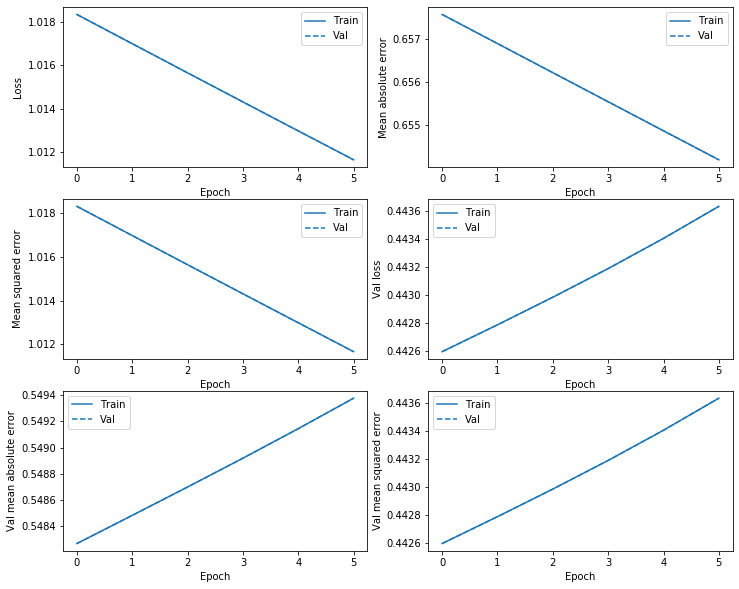

In [93]:
plot_metrics(history)

In [94]:
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 968us/step - loss: 0.4436 - mean_absolute_error: 0.5494 - mean_squared_error: 0.4436


In [95]:
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

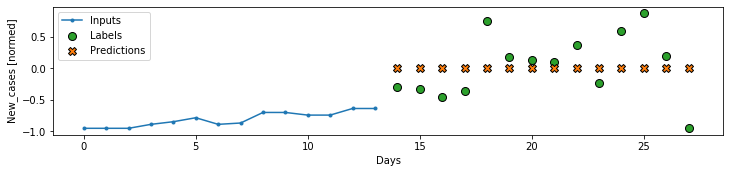

In [96]:
multi_window.plot(multi_linear_model)

In [97]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/100
1/1 [==============================] - 0s 128ms/step - loss: 1.0183 - mean_absolute_error: 0.6576 - mean_squared_error: 1.0183 - val_loss: 0.4512 - val_mean_absolute_error: 0.5542 - val_mean_squared_error: 0.4512
Epoch 2/100
1/1 [==============================] - 0s 37ms/step - loss: 1.0082 - mean_absolute_error: 0.6523 - mean_squared_error: 1.0082 - val_loss: 0.4606 - val_mean_absolute_error: 0.5607 - val_mean_squared_error: 0.4606
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 0.9978 - mean_absolute_error: 0.6468 - mean_squared_error: 0.9978 - val_loss: 0.4708 - val_mean_absolute_error: 0.5682 - val_mean_squared_error: 0.4708
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 0.9869 - mean_absolute_error: 0.6409 - mean_squared_error: 0.9869 - val_loss: 0.4818 - val_mean_absolute_error: 0.5763 - val_mean_squared_error: 0.4818
Epoch 5/100
1/1 [==============================] - 0s 33ms/step - loss: 0.9757 - mean_absolute_error: 0

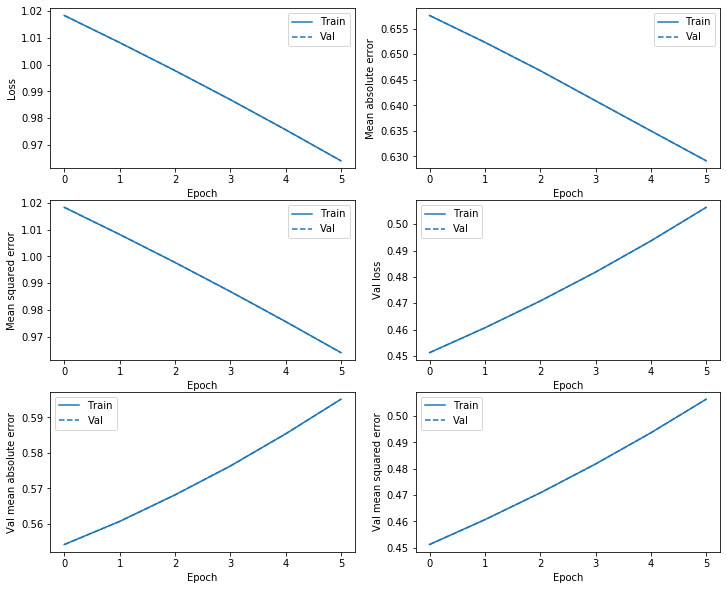

In [98]:
plot_metrics(history)

In [99]:
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 999us/step - loss: 0.5064 - mean_absolute_error: 0.5951 - mean_squared_error: 0.5064


In [100]:
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

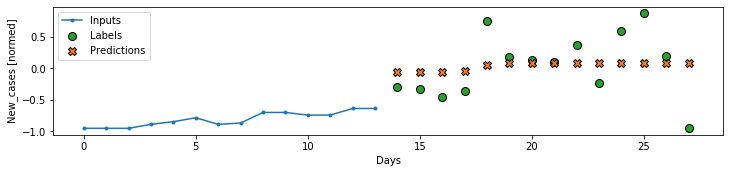

In [101]:
multi_window.plot(multi_dense_model)

In [102]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/100
1/1 [==============================] - 0s 353ms/step - loss: 1.0183 - mean_absolute_error: 0.6576 - mean_squared_error: 1.0183 - val_loss: 0.4413 - val_mean_absolute_error: 0.5473 - val_mean_squared_error: 0.4413
Epoch 2/100
1/1 [==============================] - 0s 53ms/step - loss: 1.0162 - mean_absolute_error: 0.6565 - mean_squared_error: 1.0162 - val_loss: 0.4402 - val_mean_absolute_error: 0.5465 - val_mean_squared_error: 0.4402
Epoch 3/100
1/1 [==============================] - 0s 45ms/step - loss: 1.0141 - mean_absolute_error: 0.6553 - mean_squared_error: 1.0141 - val_loss: 0.4390 - val_mean_absolute_error: 0.5456 - val_mean_squared_error: 0.4390
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 1.0119 - mean_absolute_error: 0.6542 - mean_squared_error: 1.0119 - val_loss: 0.4378 - val_mean_absolute_error: 0.5447 - val_mean_squared_error: 0.4378
Epoch 5/100
1/1 [==============================] - 0s 57ms/step - loss: 1.0095 - mean_absolute_error: 0

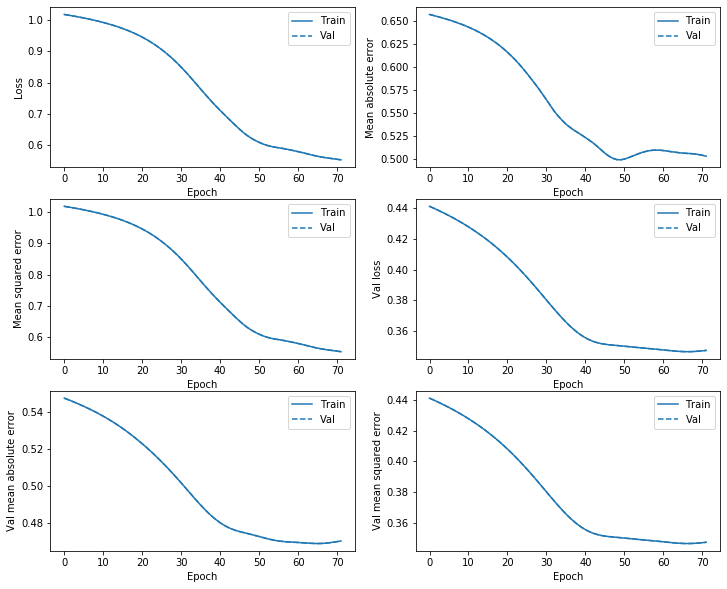

In [103]:
plot_metrics(history)

In [104]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.3471 - mean_absolute_error: 0.4701 - mean_squared_error: 0.3471


In [105]:
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

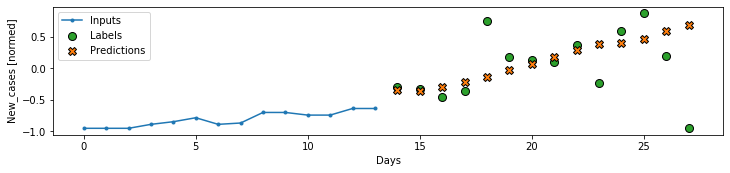

In [106]:
multi_window.plot(multi_lstm_model)

## AR model

In [107]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, num_features=num_features)

In [108]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([24, 2])

In [109]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/100
1/1 [==============================] - 0s 467ms/step - loss: 0.9857 - mean_absolute_error: 0.6367 - mean_squared_error: 0.9857 - val_loss: 0.3472 - val_mean_absolute_error: 0.4748 - val_mean_squared_error: 0.3472
Epoch 2/100
1/1 [==============================] - 0s 51ms/step - loss: 0.9728 - mean_absolute_error: 0.6294 - mean_squared_error: 0.9728 - val_loss: 0.3417 - val_mean_absolute_error: 0.4701 - val_mean_squared_error: 0.3417
Epoch 3/100
1/1 [==============================] - 0s 51ms/step - loss: 0.9597 - mean_absolute_error: 0.6218 - mean_squared_error: 0.9597 - val_loss: 0.3358 - val_mean_absolute_error: 0.4651 - val_mean_squared_error: 0.3358
Epoch 4/100
1/1 [==============================] - 0s 56ms/step - loss: 0.9462 - mean_absolute_error: 0.6138 - mean_squared_error: 0.9462 - val_loss: 0.3296 - val_mean_absolute_error: 0.4600 - val_mean_squared_error: 0.3296
Epoch 5/100
1/1 [==============================] - 0s 50ms/step - loss: 0.9323 - mean_absolute_error: 0

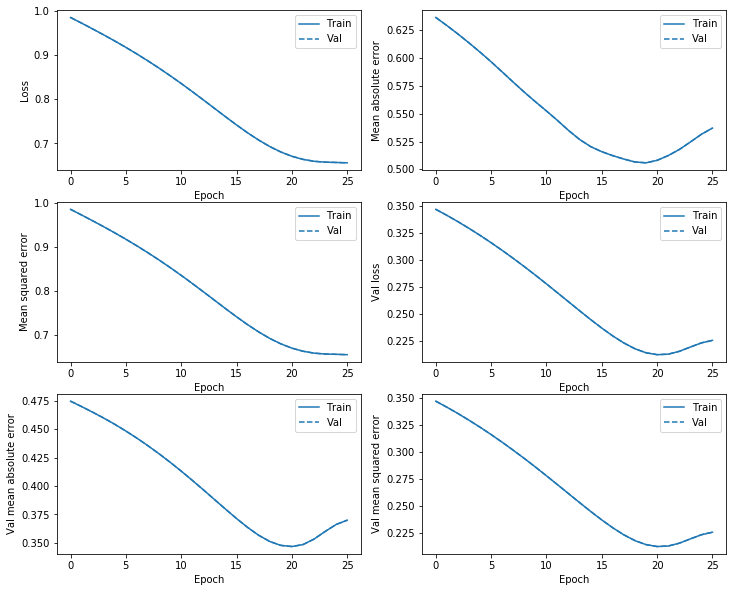

In [110]:
plot_metrics(history)

In [111]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.2255 - mean_absolute_error: 0.3699 - mean_squared_error: 0.2255


In [112]:
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

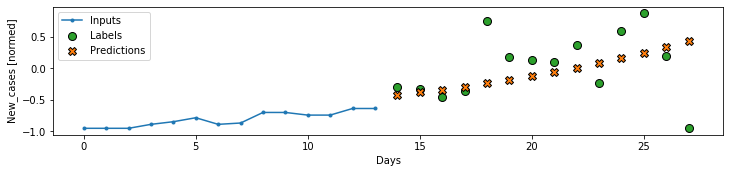

In [118]:
multi_window.plot(feedback_model)

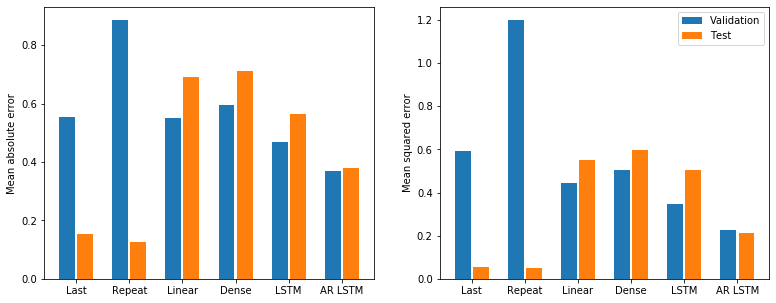

In [114]:
plot_comparison_results(multi_lstm_model.metrics_names, multi_val_performance, multi_performance, figsize=(13,5))